<a href="https://colab.research.google.com/github/affandhanbad-dev/Covid-Detection-Using-Radiography-Images/blob/main/Covid_Radiography_Detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import cv2
import os
from PIL import Image
from google.colab.patches import cv2_imshow
import zipfile
import matplotlib.image as mpimg
from tensorflow.keras import layers, models
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
import pickle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
covid19-radiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
with zipfile.ZipFile('/content/covid19-radiography-database.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [6]:
Covid_files = os.listdir('/content/COVID-19_Radiography_Dataset/COVID/images')

In [7]:
Covid_files

['COVID-2901.png',
 'COVID-3106.png',
 'COVID-350.png',
 'COVID-3339.png',
 'COVID-806.png',
 'COVID-743.png',
 'COVID-869.png',
 'COVID-1811.png',
 'COVID-2789.png',
 'COVID-2767.png',
 'COVID-176.png',
 'COVID-2306.png',
 'COVID-443.png',
 'COVID-690.png',
 'COVID-48.png',
 'COVID-2686.png',
 'COVID-3453.png',
 'COVID-2392.png',
 'COVID-1388.png',
 'COVID-2532.png',
 'COVID-3239.png',
 'COVID-581.png',
 'COVID-1930.png',
 'COVID-1608.png',
 'COVID-2498.png',
 'COVID-329.png',
 'COVID-3007.png',
 'COVID-238.png',
 'COVID-89.png',
 'COVID-1306.png',
 'COVID-2261.png',
 'COVID-1796.png',
 'COVID-1254.png',
 'COVID-1469.png',
 'COVID-2183.png',
 'COVID-3070.png',
 'COVID-286.png',
 'COVID-254.png',
 'COVID-855.png',
 'COVID-2874.png',
 'COVID-1990.png',
 'COVID-2659.png',
 'COVID-2256.png',
 'COVID-398.png',
 'COVID-2499.png',
 'COVID-1225.png',
 'COVID-675.png',
 'COVID-783.png',
 'COVID-937.png',
 'COVID-3508.png',
 'COVID-2151.png',
 'COVID-103.png',
 'COVID-17.png',
 'COVID-1926.png'

In [8]:
len(Covid_files)

3616

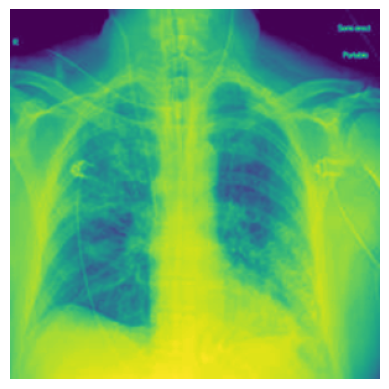

In [9]:
image = mpimg.imread('/content/COVID-19_Radiography_Dataset/COVID/images/COVID-246.png')
plt.imshow(image)
plt.axis('off')
plt.show()

In [10]:
image.shape

(299, 299)

In [11]:
classes = ['COVID','Normal','Viral Pneumonia']

In [12]:
paths = []
for cls in classes:
    folder_path = "/content/COVID-19_Radiography_Dataset/" + cls + "/images"
    paths.append(folder_path)
    images = os.listdir(folder_path)
    print(cls, ":", len(images))

COVID : 3616
Normal : 10192
Viral Pneumonia : 1345


In [13]:
paths

['/content/COVID-19_Radiography_Dataset/COVID/images',
 '/content/COVID-19_Radiography_Dataset/Normal/images',
 '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images']

In [14]:
data = []
labels = []
for path in paths:
    label = path.split('/')[-2]  # folder name as label

    for image_name in os.listdir(path):
        img_path = os.path.join(path, image_name)

        try:
            img = Image.open(img_path).resize((120,120)).convert('RGB')
            img = np.array(img)

            data.append(img)
            labels.append(label)

        except Exception as e:
            print(f"Error loading image: {img_path}")

In [15]:
labels[-1]

'Viral Pneumonia'

In [16]:
labels[2]

'COVID'

In [17]:
labels[7000]

'Normal'

In [18]:
len(labels), len(data)

(15153, 15153)

In [19]:
from keras.src.utils import to_categorical
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
labels = to_categorical(labels)

In [20]:
labels[1]

array([1., 0., 0.])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [23]:
X_train = np.array(X_train)/255
X_test = np.array(X_test)/255
X_val = np.array(X_val)/255
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [24]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((9697, 120, 120, 3),
 (3031, 120, 120, 3),
 (2425, 120, 120, 3),
 (9697, 3),
 (3031, 3),
 (2425, 3))

In [25]:
X_train

array([[[[0.07843137, 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.01960784, 0.01960784, 0.01960784],
         [0.17647059, 0.17647059, 0.17647059]],

        [[0.07843137, 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.01960784, 0.01960784, 0.01960784],
         [0.17647059, 0.17647059, 0.17647059]],

        [[0.07843137, 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.01568627, 0.01568627, 0.01568627],
         [0.17254902, 0.17254902, 0.17254902]],

        ...,

        [[0.64313725, 0.64313725, 0.64313725],
         [0.59215686, 0.59215686, 0.59215686]

In [26]:
model = Sequential()


model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(120, 120, 3), kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Dropout(0.25))


model.add(Flatten())  #
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,120,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,213,507 (19.89 MB)

 Trainable params: 5,213,507 (19.89 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [28]:
history = model.fit(X_train, y_train, batch_size=32, epochs=25,verbose = 1, validation_data=(X_val, y_val))

Epoch 1/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.7323 - loss: 0.8857 - val_accuracy: 0.8647 - val_loss: 0.3453
Epoch 2/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8792 - loss: 0.3042 - val_accuracy: 0.9039 - val_loss: 0.2433
Epoch 3/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9021 - loss: 0.2379 - val_accuracy: 0.9295 - val_loss: 0.1969
Epoch 4/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9306 - loss: 0.1794 - val_accuracy: 0.9212 - val_loss: 0.2288
Epoch 5/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9443 - loss: 0.1493 - val_accuracy: 0.9344 - val_loss: 0.1842
Epoch 6/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9532 - loss: 0.1157 - val_accuracy: 0.9423 - val_loss: 0.1599
Epoch 7/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9659 - loss: 0.0938 - val_accuracy: 0.9295 - val_loss: 0.2088
Epoch 8/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9688 - loss: 0.0885 - val_a

In [29]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9652 - loss: 0.1725
Test Loss: 0.1961470991373062
Test Accuracy: 0.9600791931152344


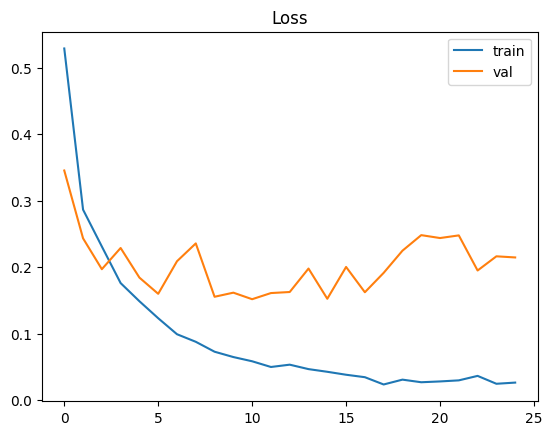

In [31]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

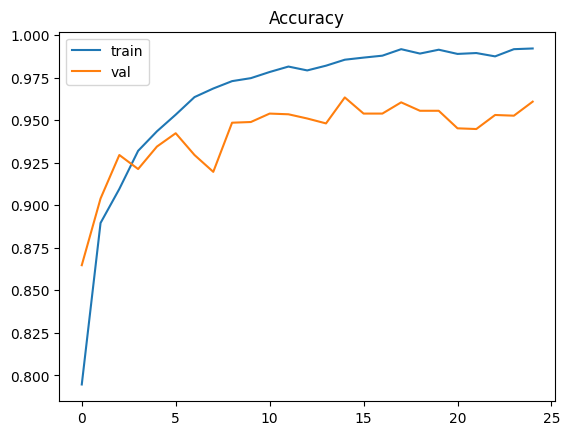

In [32]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [33]:
prediction = model.predict(X_test)

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [38]:
y_pred = np.argmax(prediction, axis=1)
y_true = np.argmax(y_test, axis=1)

In [40]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[ 676,   47,    2],
       [  47, 1963,   12],
       [   2,   11,  271]])

In [42]:
class_names = ['COVID', 'Normal', 'Viral Pneumonia']

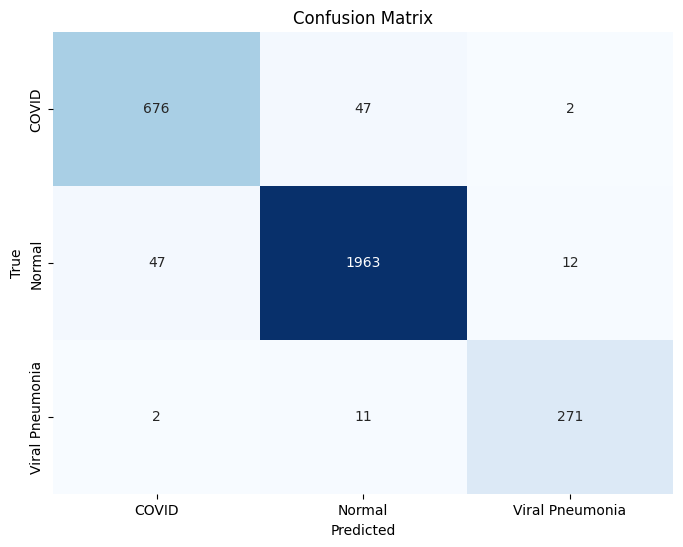

In [44]:
Confusion_Matrix = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(Confusion_Matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [49]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       725
           1       0.97      0.97      0.97      2022
           2       0.95      0.95      0.95       284

    accuracy                           0.96      3031
   macro avg       0.95      0.95      0.95      3031
weighted avg       0.96      0.96      0.96      3031



In [51]:
model.save("Covid_Radiography_Detection_model.h5")

In [53]:
with open('Covid_Radiography_Detection_model.sav', 'wb') as file:
    pickle.dump(model, file)

In [55]:
with open('Covid_Radio_label_encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


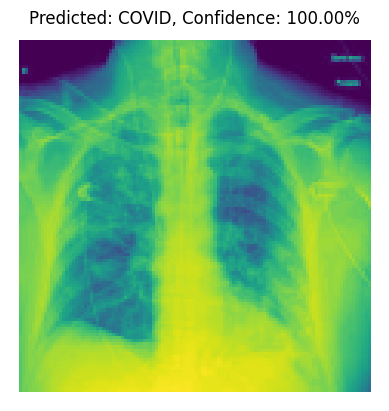

Predicted Label: COVID, Confidence Score: 100.00%


In [57]:
def detection_system(image_path, model, label_encoder, image_size=120):

    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_resized = cv2.resize(image_rgb, (image_size, image_size))

    image_normalized = image_resized / 255.0

    image_input = np.expand_dims(image_normalized, axis=0)

    predictions = model.predict(image_input)

    predicted_index = np.argmax(predictions)
    confidence_score = predictions[0][predicted_index]

    predicted_label = label_encoder.inverse_transform([predicted_index])[0]


    plt.imshow(image_resized)
    plt.title(f"Predicted: {predicted_label}, Confidence: {confidence_score*100:.2f}%")
    plt.axis('off')
    plt.show()

    return predicted_label, confidence_score

image_path = "/content/Covid_radiology.png"
predicted_label, confidence_score = detection_system(image_path, model, encoder)
print(f"Predicted Label: {predicted_label}, Confidence Score: {confidence_score*100:.2f}%")